# About run_sequence_analysis

This notebook creates dividies students into groups, loads their action sequences and runs the infogain analysis

In [1]:
%load_ext autoreload
%autoreload 1
%aimport utils_timeline_viz
%aimport utils_read_parsing
%aimport generalized_seq_miner
from utils_timeline_viz import *
from utils_read_parsing import *
from generalized_seq_miner import *
%matplotlib inline
matplotlib.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = 12,4
from matplotlib.backends.backend_pdf import PdfPages
import os
import numpy as np
import pandas as pd
import getpass
import datetime
import json
import matplotlib
import matplotlib.pyplot as plt
from itertools import groupby
from tabulate import tabulate
pd.set_option('display.max_columns', None);pd.set_option('display.max_rows', None);pd.set_option('precision', 2)
# FOLDER =  'C:\\Users\\'+getpass.getuser()+'\\Documents\\Personal Content\\Lab_skills_study\\parsed log data'

# Loading data

We grab the student learning data

In [2]:
df_all = get_df_all_factors(all_vars=False)
variables = list(set(df_all['variable']))
ids = list(set(df_all['sid']))
N = len(ids)
print 'We have',N,'students.'
print 'Running the analaysis on the following variables:',', '.join(variables)

We have 147 students.
Running the analaysis on the following variables: Width, Concentration, Separation, Area


We grab the sequences

In [3]:
import pickle
from utils_sequence_parsing import Sequence
pickle_in_seqs = open(os.path.join(BIG_FOLDER,'all_massaged_data\\dict_by_sim_by_student_parsed_seqs.txt'),"r")
all_seqs = pickle.load(pickle_in_seqs)
pickle_in_seqs.close()

# Splitting students

## Count number of "exact" main scores in each activity (1 and 2)

In [4]:
df_all.head(6)

,sid,sim,variable,pre,main,cvs_graph,cvs_table,cvs_table_only,cvs_graph_inverse,cvs_graph_axes,qual_score,quant_score,activity_order,sim_index,similar_sim,lab_experience,lab_experience_chem,lab_experience_phys,prior_number_virtual_labs,overall POCC,PC1,PC2,pre_with_ident,main_with_ident,CVS_context,use_table,use_graph,use_concentration,use_width,use_area,use_separation,use_all_vars,use_graph_beers,use_table_beers,use_table_capacitor,use_graph_capacitor
0,10127163,L,Concentration,0.0,2.0,1.0,1.0,0.0,0,1.0,1.0,1.0,LC,1,0,1.0,1.0,1.0,1,17,-0.62,0.63,1.0,3.0,2.0,1,1,1,1,1,1,4,1,1,1,1
1,10127163,L,Width,0.0,2.0,1.0,1.0,0.0,0,1.0,1.0,1.0,LC,1,0,1.0,1.0,1.0,1,17,-0.62,0.63,1.0,3.0,2.0,1,1,1,1,1,1,4,1,1,1,1
2,10127163,C,Area,2.0,2.0,1.0,1.0,0.0,0,1.0,1.0,1.0,LC,2,0,1.0,1.0,1.0,1,17,-0.62,0.63,3.0,3.0,2.0,1,1,1,1,1,1,4,1,1,1,1
3,10127163,C,Separation,2.0,2.0,1.0,1.0,0.0,1,2.0,1.0,1.0,LC,2,0,1.0,1.0,1.0,1,17,-0.62,0.63,3.0,3.0,2.0,1,1,1,1,1,1,4,1,1,1,1
4,10232160,L,Concentration,0.0,0.0,1.0,1.0,0.0,1,2.0,1.0,1.0,LC,1,1,1.0,1.0,1.0,1,15,-1.04,-0.42,1.0,1.0,2.0,1,1,1,1,1,1,4,1,1,1,1
5,10232160,L,Width,0.0,0.0,0.0,0.0,0.0,0,0.0,1.0,1.0,LC,1,1,1.0,1.0,1.0,1,15,-1.04,-0.42,1.0,1.0,0.0,1,1,1,1,1,1,4,1,1,1,1


In [5]:
def count_exact(scores):
    return int(sum([s==2.0 for s in scores]))

In [6]:
scores = pd.pivot_table(df_all, values=['pre','main'], index=['sid','sim_index'], aggfunc=count_exact)
scores.reset_index().set_index('sid',inplace=True)
scores.head()

main  pre
sid      sim_index           
10127163 1           2.0  0.0
         2           2.0  2.0
10192168 1           0.0  0.0
         2           1.0  0.0
10232160 1           0.0  0.0

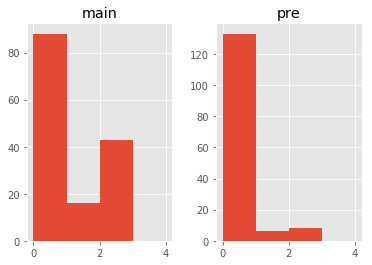

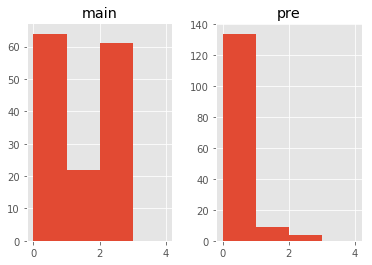

In [7]:
scores.groupby('sim_index').hist(bins=range(5));

## What if we split by increase or decrease in number of exact scores from pre to main?

In [8]:
def make_group(row):
    if row['pre']==2:
        return 'Hpre'
    elif row['pre']==0 and row['main']==0:
        return 'LU'
    elif row['pre']==0 and row['main']==1:
        return 'LP'
    elif row['pre']==0 and row['main']==2:
        return 'LP'
    elif row['pre']==1 and row['main']==0:
        return 'MU'
    elif row['pre']==1 and row['main']==1:
        return 'MU'
    elif row['pre']==1 and row['main']==2:
        return 'MP'
    else:
        print row
    
scores['group'] = scores.apply(make_group,axis=1)

In [9]:
scores.groupby(['sim_index','group']).describe()

main                                        pre            \
                count  mean   std  min  25%  50%  75%  max count mean  std   
sim_index group                                                              
1         Hpre    8.0  2.00  0.00  2.0  2.0  2.0  2.0  2.0   8.0  2.0  0.0   
          LP     48.0  1.71  0.46  1.0  1.0  2.0  2.0  2.0  48.0  0.0  0.0   
          LU     85.0  0.00  0.00  0.0  0.0  0.0  0.0  0.0  85.0  0.0  0.0   
          MP      1.0  2.00   NaN  2.0  2.0  2.0  2.0  2.0   1.0  1.0  NaN   
          MU      5.0  0.40  0.55  0.0  0.0  0.0  1.0  1.0   5.0  1.0  0.0   
2         Hpre    4.0  1.50  1.00  0.0  1.5  2.0  2.0  2.0   4.0  2.0  0.0   
          LP     71.0  1.70  0.46  1.0  1.0  2.0  2.0  2.0  71.0  0.0  0.0   
          LU     63.0  0.00  0.00  0.0  0.0  0.0  0.0  0.0  63.0  0.0  0.0   
          MP      8.0  2.00  0.00  2.0  2.0  2.0  2.0  2.0   8.0  1.0  0.0   
          MU      1.0  1.00   NaN  1.0  1.0  1.0  1.0  1.0   1.0  1.0  NaN   

                                          
                 min  25%  50%  75%  max  
sim_index group                           
1         Hpre   2.0  2.0  2.0  2.0  2.0  
          LP     0.0  0.0  0.0  0.0  0.0  
          LU     0.0  0.0  0.0  0.0  0.0  
          MP     1.0  1.0  1.0  1.0  1.0  
          MU     1.0  1.0  1.0  1.0  1.0  
2         Hpre   2.0  2.0  2.0  2.0  2.0  
          LP     0.0  0.0  0.0  0.0  0.0  
          LU     0.0  0.0  0.0  0.0  0.0  
          MP     1.0  1.0  1.0  1.0  1.0  
          MU     1.0  1.0  1.0  1.0  1.0

We drop High pre (Hpre), nd those that unlearned (MU and MP)

In [10]:
scores = scores[scores['group'].isin(['LU','LP'])]
scores.groupby(['sim_index','group']).describe()

main                                        pre            \
                count  mean   std  min  25%  50%  75%  max count mean  std   
sim_index group                                                              
1         LP     48.0  1.71  0.46  1.0  1.0  2.0  2.0  2.0  48.0  0.0  0.0   
          LU     85.0  0.00  0.00  0.0  0.0  0.0  0.0  0.0  85.0  0.0  0.0   
2         LP     71.0  1.70  0.46  1.0  1.0  2.0  2.0  2.0  71.0  0.0  0.0   
          LU     63.0  0.00  0.00  0.0  0.0  0.0  0.0  0.0  63.0  0.0  0.0   

                                          
                 min  25%  50%  75%  max  
sim_index group                           
1         LP     0.0  0.0  0.0  0.0  0.0  
          LU     0.0  0.0  0.0  0.0  0.0  
2         LP     0.0  0.0  0.0  0.0  0.0  
          LU     0.0  0.0  0.0  0.0  0.0

### How to people transition from one group to another from activity 1 to 2?

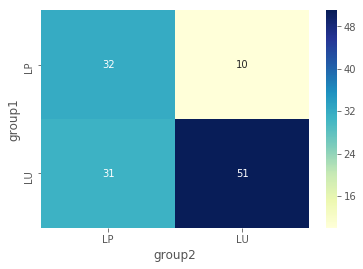

In [11]:
df_all = df_all.merge(scores[['group']], how='outer', on=['sid','sim_index']);
df_all.dropna(inplace=True)
combogroups = df_all[df_all['sim_index']==1][['sid','group']].rename(columns={'group':'group1'}).merge(df_all[df_all['sim_index']==2][['sid','group']].rename(columns={'group':'group2'}), how='outer', on=['sid']);
combogroups.drop_duplicates(inplace=True)
sns.heatmap(pd.pivot_table(combogroups, index='group1',columns='group2',values='sid',aggfunc=len),cmap="YlGnBu",annot=True)#.fillna(0))

The bulk of students go from LL to LH or remain in their original group.

## What if we split by those who had at least one instance of pre=2

In [12]:
# def make_group(row):
#     if row['pre']>0:
#         if row['main']>0:
#             return 'HH'
#         else:
#             return 'HL'
#     else:
#         if row['main']>0:
#             return 'LH'
#         else:
#             return 'LL'
    
# scores['group'] = scores.apply(make_group,axis=1)

In [13]:
# scores.groupby(['sim_index','group']).describe()

There are many more LH than LL in activity 2, the opposite in activity 1.
The number of H_ remains the same.

### How to people transition from one group to another from activity 1 to 2?

In [14]:
# df_all = df_all.merge(scores[['group']], how='outer', on=['sid','sim_index']);
# combogroups = df_all[df_all['sim_index']==1][['sid','group']].rename(columns={'group':'group1'}).merge(df_all[df_all['sim_index']==2][['sid','group']].rename(columns={'group':'group2'}), how='outer', on=['sid']);
# combogroups.drop_duplicates(inplace=True)
# sns.heatmap(pd.pivot_table(combogroups, index='group1',columns='group2',values='sid',aggfunc=len),cmap="YlGnBu",annot=True)#.fillna(0))

**grey boxes have 0 students**

* Most LL students remain LL (48) and never model an exact relationship
* Many LL become LH (29)
* Many HH students remain high learning despite lower pres in 2nd activity (10)

## What if we split by learning gains from activity 1

We use the following formula for learning gains:

$gain = \frac{main-pre}{max\_score-pre}$

where max_score is the number of variables

In [15]:
max_score = len(variables)
scores['gains'] = (scores['main']-scores['pre'])/(max_score - scores['pre'])
t = scores['gains'].value_counts().sort_index()
t

0.00    148
0.25     35
0.50     84
Name: gains, dtype: int64

* LL 97 students had null or negative learning gains
* LH 58 students had learning gain

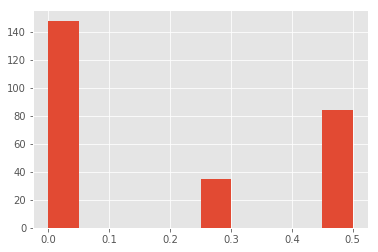

In [16]:
scores['gains'].hist()

# Running analysis

## Setting up the data

We limit it to the first activity

In [17]:
df_all = df_all[df_all['sim_index']==1]

In [18]:
len(df_all['sid'].unique())

133

We transform the sequences by blocking certain actions, removing others, merging some and generalizing

In [19]:
transformed_seqs = {}
for sim,seqs_by_student in all_seqs.iteritems():
    transformed_seqs[sim] = {}
    for sid,seq in seqs_by_student.iteritems():
        seq.remove_actions('ignore')
        seq.remove_actions('V_ruler')
        seq.merge_actions(['P','P_notes'])
        seq.block_actions(['P','V_area', 'V_battery', 'V_lightbulb', 'V_separation','V_other','V_width','V_concentration','V_wavelength','V_detector','V_laser'])
        seq.block_actions(['G_add','G_add_fail','G_remove','T_remove'])
        seq.translate_variable_actions()
        seq.check_lengths_seq_timecoords()
        transformed_seqs[sim][sid] = seq

In [20]:
def get_levels_and_students_per_attribute(df, attribute):
    d={}
    levels = list(df[attribute].unique())
    print levels
    for level in levels:
        d[level] = list(df[df[attribute]==level]['sid'].unique())
    return levels,d
    
# levels, students_by_attribute = get_levels_and_students_per_attribute(df_all[df_all['variable']=='Concentration'], 'group')
levels, students_by_attribute = get_levels_and_students_per_attribute(df_all, 'group')
for level in levels:
    print level, len(students_by_attribute[level])
# students_by_attribute.pop('HL', None)
# levels.remove('HL')

['LP', 'LU']
LP 48
LU 85


In [22]:
attribute = 'group'
level1 = 'LU'
level2 = 'LP'

In [23]:
df_all.head()

,sid,sim,variable,pre,main,cvs_graph,cvs_table,cvs_table_only,cvs_graph_inverse,cvs_graph_axes,qual_score,quant_score,activity_order,sim_index,similar_sim,lab_experience,lab_experience_chem,lab_experience_phys,prior_number_virtual_labs,overall POCC,PC1,PC2,pre_with_ident,main_with_ident,CVS_context,use_table,use_graph,use_concentration,use_width,use_area,use_separation,use_all_vars,use_graph_beers,use_table_beers,use_table_capacitor,use_graph_capacitor,group
0,10127163,L,Concentration,0.0,2.0,1.0,1.0,0.0,0,1.0,1.0,1.0,LC,1,0,1.0,1.0,1.0,1,17,-0.62,0.63,1.0,3.0,2.0,1,1,1,1,1,1,4,1,1,1,1,LP
1,10127163,L,Width,0.0,2.0,1.0,1.0,0.0,0,1.0,1.0,1.0,LC,1,0,1.0,1.0,1.0,1,17,-0.62,0.63,1.0,3.0,2.0,1,1,1,1,1,1,4,1,1,1,1,LP
4,10232160,L,Concentration,0.0,0.0,1.0,1.0,0.0,1,2.0,1.0,1.0,LC,1,1,1.0,1.0,1.0,1,15,-1.04,-0.42,1.0,1.0,2.0,1,1,1,1,1,1,4,1,1,1,1,LU
5,10232160,L,Width,0.0,0.0,0.0,0.0,0.0,0,0.0,1.0,1.0,LC,1,1,1.0,1.0,1.0,1,15,-1.04,-0.42,1.0,1.0,0.0,1,1,1,1,1,1,4,1,1,1,1,LU
10,10537160,C,Area,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,CL,1,0,1.0,1.0,0.0,1,9,3.03,-0.43,0.0,0.0,0.0,1,0,1,1,1,1,4,0,1,1,0,LU


In [24]:
seqs_dict = {}
timecoords_dict = {}

for i,row in df_all[df_all['sim_index']==1][['sid','sim']].drop_duplicates().iterrows():
    sim = {'L':'beers','C':'capacitor'}[row['sim']]
    sid = row['sid']
    seqs_dict[sid] = transformed_seqs[sim][sid].seq
    start_times = transformed_seqs[sim][sid].timecoords
    #add durations
    timecoords_dict[sid] = [(round(t,3),round(start_times[i+1]-t,3)) if i<len(start_times)-1 else (t,1) for i,t in enumerate(start_times)]

## Setting parameters

In [25]:
#We split activities into 3 time bins
num_bins = 3
#Sequences of action of interest can be a minimum and max length
shortest_seq_length = 2
longest_seq_length = 10
# for mining sequences in large groups, we want to make sure we find interesting sequences that have been done by a minimum number of people.
# Thus we use a cut off of 0.3-0.5 to only analyze sequences done by at least 30-50% of students within a group.
# Thus the groups can have slightly different sizes.
cut_off = 0.33

## Running the sequence mining

In [26]:
%aimport generalized_seq_miner
freqs = get_frequencies_by_bin(seqs_dict,timecoords_dict, num_bins, shortest=shortest_seq_length, longest=longest_seq_length)

In [27]:
freqs[10127163][0].most_common(5)

[('V_quant,V_qual', 5),
 ('Switch_quant,V_quant', 5),
 ('Switch_quant,V_quant,V_qual', 4),
 ('V_quant,Switch_quant', 3),
 ('V_quant,Switch_quant,V_quant', 3)]

In [28]:
# The code below finds, for each sequence, the number of students in each group that used that sequence at least once in that time bin
# For instance, for the sequence 'BCB': array([[ .2,  1.],[ 1.,  0.]]), it was used at least once by 2 of the students in the "passed" group in the first half of their activity.
seq_use = get_sequence_use_by_timebin(seqs_dict,timecoords_dict, students_by_attribute, num_bins, attribute,
            levels, shortest_seq_length, longest_seq_length, cut_off)

In [29]:
## Now we can calculate the information gain of this sequence over groups in time. In other words, high information gain sequences
# are used differently over time by groups while low information gain sequences are used closer to randomly by groups over time.
tops = rank_sequences(seq_use,num_bins)[-20:]
tops.sort(key=lambda tup: tup[1],reverse=True)
for s,f in tops:
    print round(f,3),'\t',s

1.078 	V_other,V_laser
0.534 	T_add,V_quant,T_add,V_quant,T_add,G_add
0.512 	V_quant,T_add,V_quant,T_add,V_quant,T_add,G_add
0.49 	V_quant,T_add,V_quant,T_add,G_add
0.483 	T_add,V_quant,T_add,V_quant,T_add,V_quant,T_add,G_add
0.481 	T_add,V_quant,T_add,V_quant,T_add,V_quant,T_add,V_quant,T_add,G_add
0.461 	V_qual,P,V_qual,P
0.455 	V_quant,T_add,V_quant,T_add,V_quant,T_add,V_quant,T_add,G_add
0.443 	T_add,V_quant,T_add,G_add
0.441 	Switch_quant,V_quant,T_add,V_quant,T_add,V_quant,T_add,V_quant,T_add,V_quant
0.41 	V_quant,Switch_quant,V_quant,T_add,V_quant
0.385 	V_qual,V_quant,Switch_quant,V_quant
0.385 	V_qual,V_quant,Switch_quant
0.383 	G_scale_linear,P
0.369 	Switch_quant,V_quant,T_add,V_quant,T_add,V_quant,T_add,V_quant,T_add
0.361 	Switch_quant,V_quant,T_add,V_quant,T_add,V_quant,T_add,V_quant
0.35 	V_quant,T_add,G_add
0.338 	Switch_quant,V_quant,T_add,V_quant,T_add,V_quant,T_add
0.333 	V_quant,Switch_quant,V_quant,V_qual
0.333 	P,V_qual,P,V_qual


## Make viz

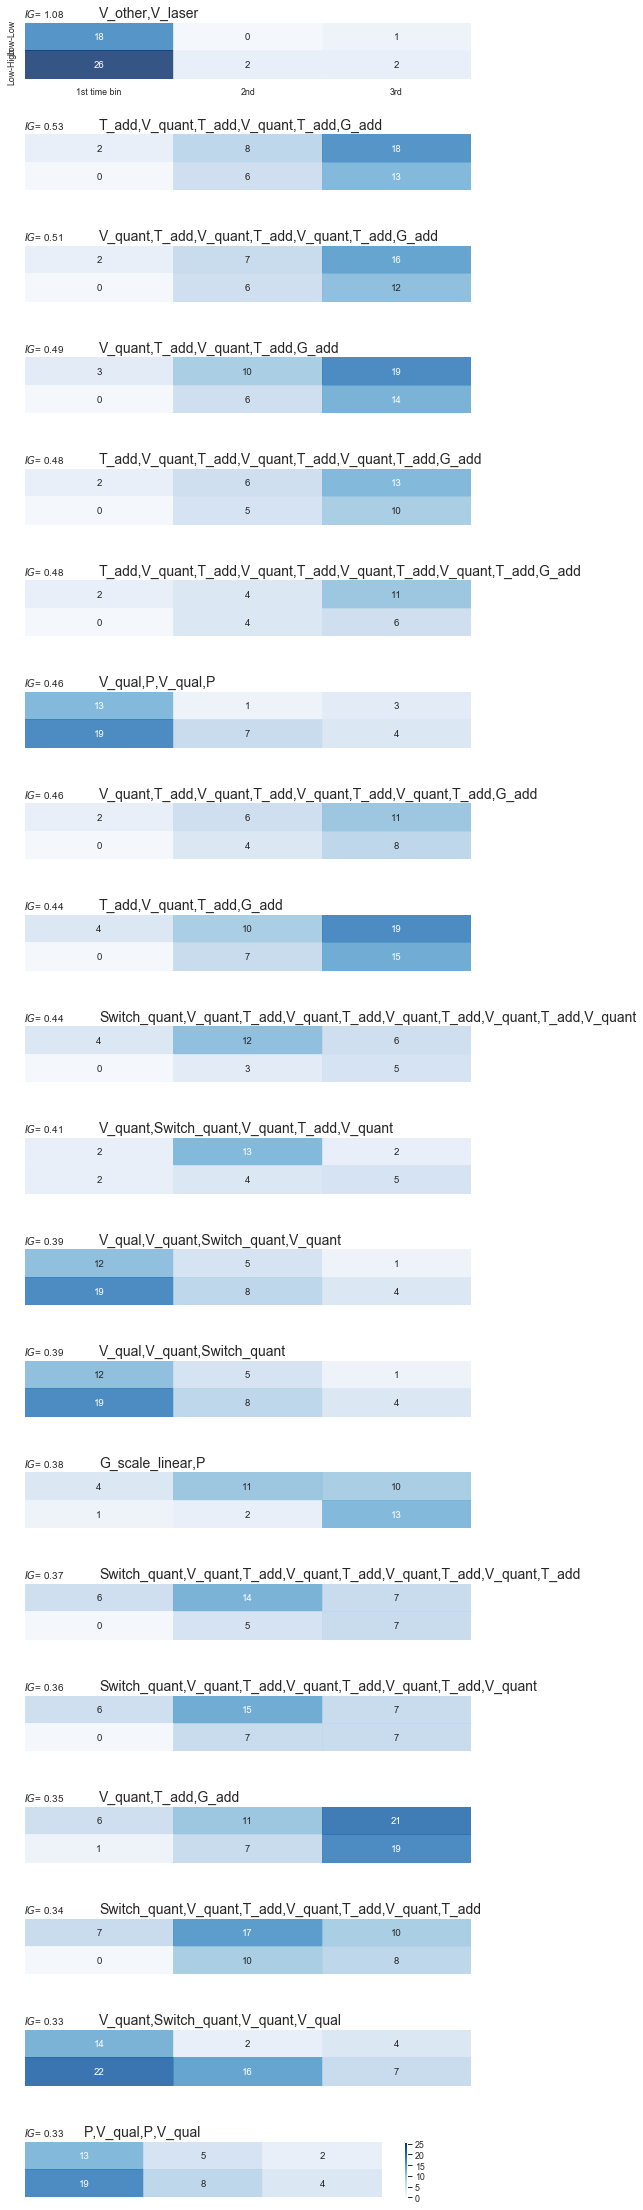

In [30]:
sns.set_style("darkgrid")
sns.set_context("paper")
seqs_plot = zip(*tops)[0]
fig, axes = plt.subplots(len(seqs_plot),1,figsize=(8,40))#, sharex=True, sharey=True)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=1)
maximum = int(max([np.amax(counts) for seq,counts in seq_use.iteritems() if seq in seqs_plot]))
for i,(seq,ig) in enumerate(tops):
    ax = axes[i]
    data = seq_use[seq]
    ax.text(0.5,-0.2, seq, fontsize=14)
    ax.text(0,-0.2, "$IG$= {0}".format(str(round(ig,2))), fontsize=10)

    # heatmap = ax.pcolor(data, cmap=plt.cm.Blues, alpha=0.8, vmin=0)
    heatmap = sns.heatmap(data, ax=ax, cmap=plt.cm.Blues,alpha=0.8, vmin=0, vmax=maximum, cbar=False,
                          annot=True) #, annot_kws={'fontweight':'bold'})

    if i==0:
        xlabels = map(str, np.arange(data.shape[1])+1) 
        xlabels = ['1st time bin','2nd','3rd']
        ax.set_xticklabels([],)
        ax.set_xticks(np.arange(data.shape[1]) + 0.5)
        ax.set_xticklabels(xlabels)
        ax.set_yticks(np.arange(data.shape[0]))
        ylabels = ['Low-Low','Low-High']
        ax.set_yticklabels(ylabels)

        cbar = ax.figure.colorbar(ax.collections[0])
#         cbar.set_ticks([0,1,3,5,7,9,11,13])
#         cbar.set_ticklabels([0,1,3,5,7,9,11,13])
    else: 
        ax.set_xticklabels(['','','',''])
        ax.set_yticklabels(['',''])

        

#     cbar = ax.figure.colorbar(ax.collections[0])
#     cbar.set_ticks([0,1,3,5,7,9,11,13])
#     cbar.set_ticklabels([0,1,3,5,7,9,11,13])

#     fig.set_size_inches(4,1.6*len(all_seqs))
#     ax.set_frame_on(False)
#     ax.tick_params(
#         axis='both',        # changes apply to both the x and y-axis
#         which='both',       # both major and minor ticks are affected
#         bottom='off',       # ticks along the those edges are off
#         right='off', 
#         left='off',
#         top='off') 
# fig.savefig('heatmap_all.svg')